# YOLO Model - PyTorch
Replication of the Yolo Model in Pytorch.

In [1]:
import os
import scipy.io
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from matplotlib.patches import Rectangle, Circle
from tqdm import tqdm_notebook

In [ ]:
mat = scipy.io.loadmat('yolo_v3/data/cars_meta.mat')
meta_data = pd.DataFrame(mat['class_names'][0]).applymap(np.squeeze)
#meta_data.index = annot_data.fname
# meta_data.drop('fname', axis=1, inplace=True)
meta_data.head(10)

In [3]:
mat = scipy.io.loadmat('yolo_v3/data/cars_train_annos.mat')
annot_data = pd.DataFrame(mat['annotations'][0]).applymap(np.squeeze)
annot_data.index = annot_data.fname
annot_data.drop('fname', axis=1, inplace=True)
annot_data.head(10)

bbox_x1  bbox_y1  bbox_x2  bbox_y2  class
fname                                               
00001.jpg       39      116      569      375     14
00002.jpg       36      116      868      587      3
00003.jpg       85      109      601      381     91
00004.jpg      621      393     1484     1096    134
00005.jpg       14       36      133       99    106
00006.jpg      259      289      515      416    123
00007.jpg       88       80      541      397     89
00008.jpg       73       79      591      410     96
00009.jpg       20      126     1269      771    167
00010.jpg       21      110      623      367     58

In [2]:
def show_image(img, ax=None):
    """
    Show Image in the path variable.
    """
    if isinstance(img, str):
        image = Image.open(img)
    else:
        image = img
    if ax is None:
        f = plt.figure(figsize=(12,10))
        ax = f.add_subplot(1, 1, 1, xticks=[], yticks=[])
    ax.imshow(image)
    return ax

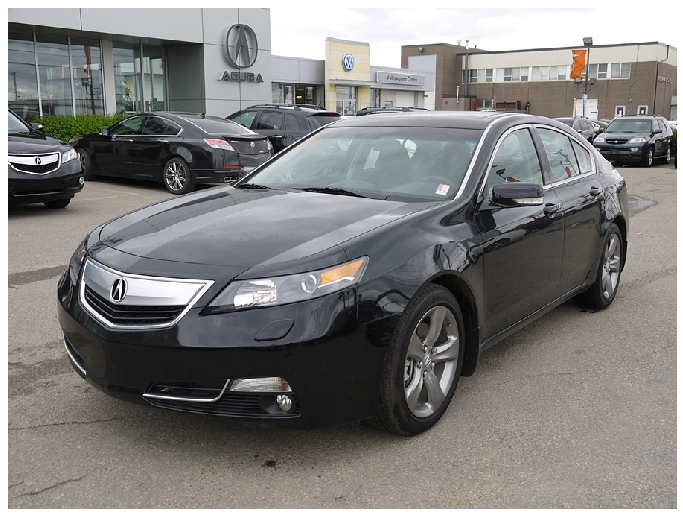

In [69]:
path = '.\\yolo_v3\\data\\cars_train\\00002.jpg'
show_image(path)

## Show Annotations

(900, 675)


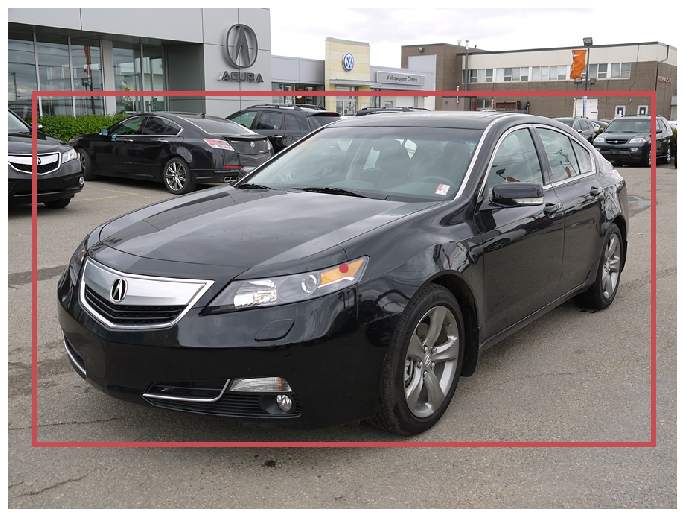

In [6]:
def show_annotation(img_path, ax=None):
    ax = show_image(img_path, ax)
    img_name = img_path.split('\\')[-1]
    bbox_x1, bbox_y1, bbox_x2, bbox_y2, _ = annot_data.loc[img_name]
    rect = Rectangle((bbox_x1, bbox_y1), bbox_x2 - bbox_x1, bbox_y2 - bbox_y1, linewidth=5, edgecolor='r', facecolor='none')
    c = Circle((bbox_x1+ (bbox_x2-bbox_x1)/2, bbox_y1 +(bbox_y2-bbox_y1)/2), 3, linewidth=5, edgecolor='r')
    ax.add_patch(c)
    ax.add_patch(rect)
    return ax
show_annotation(path)

(600, 400)
(900, 675)
(640, 480)
(2100, 1386)
(144, 108)
(575, 431)
(640, 480)
(639, 480)
(1280, 843)


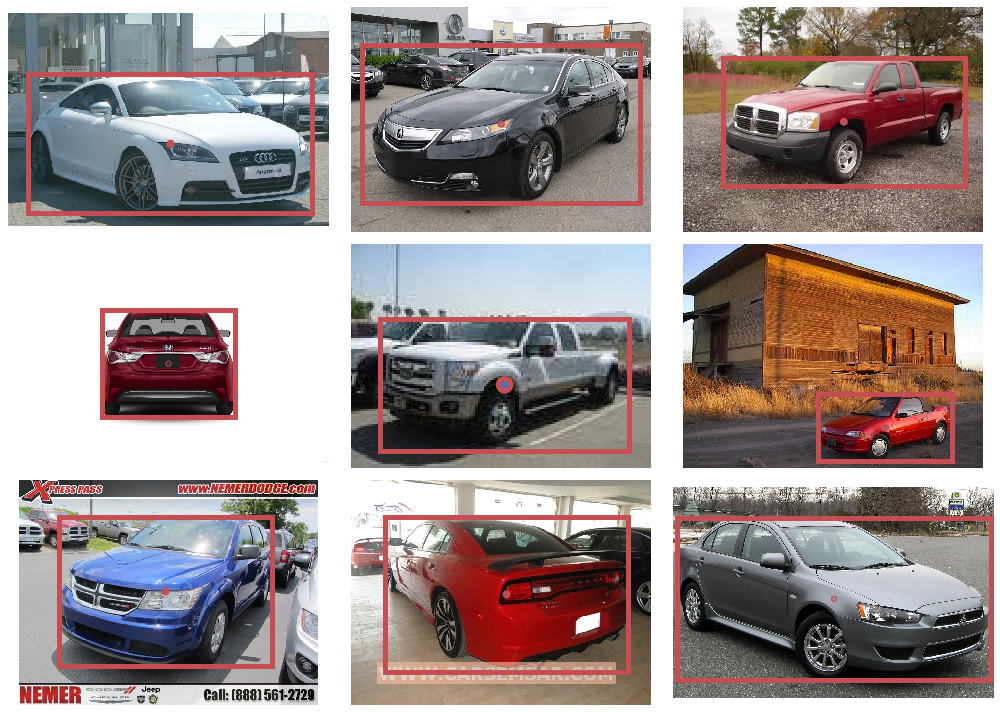

In [7]:
# Examples of Data
f, axes = plt.subplots(3, 3, subplot_kw={'xticks':[], 'yticks':[]}, figsize=(14, 10))
plt.tight_layout()
path_init = '.\\yolo_v3\\data\\cars_train\\0000'
for i in range(9):
    p = path_init + str(i + 1) + '.jpg'
    show_annotation(p, axes[i // 3, i % 3])

# Prepare Data

In [8]:
GRID = 7
N_CLASS = 4
IMG_SIZE = (448, 448)
# Target vectors
def create_target_volume(path, cls='car'):
    """
    y = [pos, b_x, b_y, b_w, b_h, car, motorcycle, truck, bus]
    """
    
    img = Image.open(path)
    img_init_width, img_init_height = img.size
    img = img.resize(IMG_SIZE)
    img_data = np.array(img)
    img_height, img_width = img_data.shape[:2]
    
    # Ratio
    width_ratio = img_width / img_init_width
    height_ratio = img_height / img_init_height
    grid_height, grid_width = (img_height // GRID, img_width // GRID)
    img_name = path.split('\\')[-1]
    # Baunding box data
    bbox_x1, bbox_y1, bbox_x2, bbox_y2, _ = annot_data.loc[img_name]

    # Center of annotation
    mid_x, mid_y = (bbox_x1 + (bbox_x2 - bbox_x1) / 2) * width_ratio, (bbox_y1 +(bbox_y2 - bbox_y1) / 2) * height_ratio
    # Target
    target = np.zeros((GRID, GRID, 5 + N_CLASS))
    n_grid_x = int(mid_x // grid_width)
    n_grid_y = int(mid_y // grid_height)
    target[n_grid_x, n_grid_y, 0] = 1
    target[n_grid_x, n_grid_y, 1] = (mid_x - n_grid_x * grid_width) / grid_width
    target[n_grid_x, n_grid_y, 2] = (mid_y - n_grid_y * grid_height) / grid_height
    target[n_grid_x, n_grid_y, 3] = (bbox_x2 - bbox_x1) * width_ratio / grid_width
    target[n_grid_x, n_grid_y, 4] = (bbox_y2 - bbox_y1) * height_ratio / grid_height
    if cls == 'car':
        target[n_grid_x, n_grid_y, 5] = 1
    elif cls == 'motorcycle':
        target[n_grid_x, n_grid_y, 6] = 1
    elif cls == 'truck':
        target[n_grid_x, n_grid_y, 7] = 1
    elif cls == 'bus':
        target[n_grid_x, n_grid_y, 8] = 1
    
    return target

In [9]:
arr = create_target_volume(path)
arr[arr > 0]

array([1.        , 0.51555556, 0.64518519, 6.47111111, 4.88444444,
       1.        ])

(448, 448)


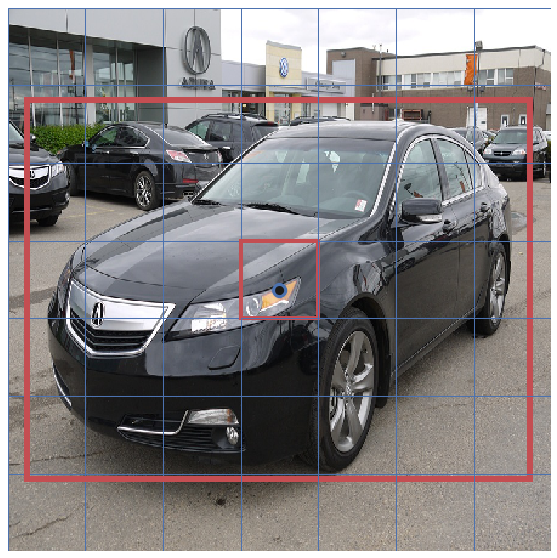

In [10]:
def show_target_volume(path):
    img = Image.open(path).resize(IMG_SIZE)
    img_data = np.array(img)
    
    img_height, img_width = img_data.shape[:2]
    grid_height, grid_width = (img_height // GRID, img_width // GRID)
    ax = show_image(img)
    
    target = create_target_volume(path)
    for i in range(GRID):
        for j in range(GRID):
            rel_x = i * grid_width
            rel_y = j * grid_height
            rect = Rectangle((rel_x, rel_y), grid_width, grid_height, linewidth=1,
                             edgecolor='b', facecolor='none')
            if target[i, j, 0] == 1:
                delta_x, delta_y = target[i, j, 3:5]
                x, y = target[i, j, 1:3]
                x, y = int(rel_x + x * grid_width), int(rel_y + y * grid_height)
                bound_rect = Rectangle((int(x - delta_x / 2 * grid_width),
                                        int(y - delta_y/2 * grid_height)),
                                       int(delta_x * grid_width),
                                       int(delta_y * grid_height),
                                       linewidth=6, edgecolor='r', facecolor='none')

                mid_circ = Circle((x, y), 5, linewidth=3, edgecolor='b',
                                  facecolor='k')
                rect.set_edgecolor('r')
                rect.set_linewidth(4)
                ax.add_patch(bound_rect)
                ax.add_patch(mid_circ)
            
            ax.add_patch(rect)
    
    return ax
show_target_volume(path)

# Create Target Volume Data

In [4]:
# For each image in train data
N_IMGS = 8144
target_df = pd.DataFrame(index=range(N_IMGS), columns=['img_path', 'target_vol'])
glob_gen = glob.iglob('.\\yolo_v3\\data\\cars_train\\*.jpg')
for i, f in tqdm_notebook(enumerate(glob_gen), total=N_IMGS):
    target_df.iloc[i] = [f, create_target_volume(f)]

In [13]:
# Check
print(target_df.loc[1, 'target_vol'][3, 3])
print(type(target_df.loc[1, 'target_vol']))
target_df.head()

[1.         0.51555556 0.64518519 6.47111111 4.88444444 1.
 0.         0.         0.        ]
<class 'numpy.ndarray'>


img_path  \
0  .\yolo_v3\data\cars_train\00001.jpg   
1  .\yolo_v3\data\cars_train\00002.jpg   
2  .\yolo_v3\data\cars_train\00003.jpg   
3  .\yolo_v3\data\cars_train\00004.jpg   
4  .\yolo_v3\data\cars_train\00005.jpg   

                                          target_vol  
0  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
1  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
2  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
3  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
4  [[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

# Create Data Loader - Pytorch

In [3]:
import torch
from torch import nn
from torch import optim
import torch.functional as F
from torchvision import transforms as T
from torchvision import models
from itertools import combinations, chain
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader, random_split

In [4]:
class CarsDataset(Dataset):
    """
    Creates the dataset ready to apply triplet loss.
    """
    def __init__(self, dataframe, root_dir=None, transform=None):
        """
        Args:
            dataframe: Data frame with the images paths and volume.
            root_dir: Root directory of the images.
            transform: Tranformation applied to the images.
        
        Return:
            Dataset
        """ 
        # Attributes
        self.data = dataframe
        if root_dir is None:
            self.root_dir = ""
        else:
            self.root_dir = root_dir
        
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        
        if type(idx) == torch.Tensor:
            idx = idx.item()
        # Load images
        img_path = os.path.join(self.root_dir,
                                self.data.iloc[idx, 0])
        img = Image.open(img_path).convert('RGB')
        volume = torch.from_numpy(self.data.iloc[idx, 1])
        
        # Data augmentation
        if self.transform:
            img = self.transform(img)
        
        # Output
        sample = (img, volume)
        
        return sample

In [16]:
# OBS.: No Data augmentation
transform = T.Compose([T.Resize(IMG_SIZE),
                       T.ToTensor()
                      ])
# T.Normalize(mean=[0.485, 0.456, 0.406],
#                                    std=[0.229, 0.224, 0.225])
# Dataset
dataset = CarsDataset(target_df, transform=transform)

In [17]:
# Train Test Split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

torch.Size([3, 448, 448])
torch.Size([7, 7, 9])


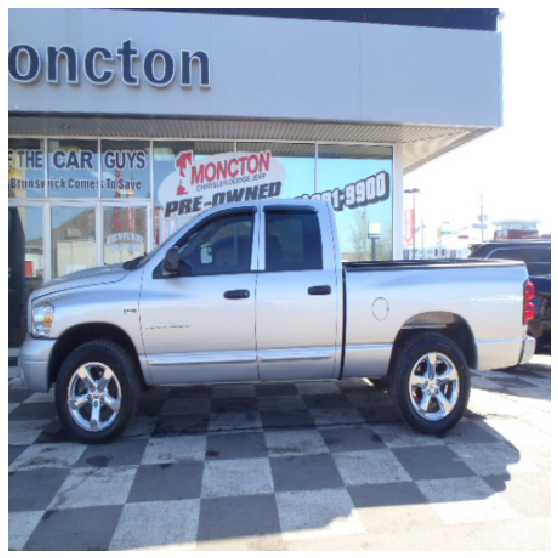

In [18]:
# Load data
iter_data = iter(train_dataset)
next(iter_data)
img1, vol = next(iter_data)

# Check the size of the images
print(img1.size())
print(vol.size())

# Check the images
imgs_1 = img1.numpy()

# Plot images
f = plt.figure(figsize=(28, 10))
ax1 = f.add_subplot(1, 1, 1, xticks=[], yticks=[])
ax1.imshow(np.transpose(imgs_1, (1, 2, 0)))

In [12]:
# Save volume
# target_df.to_pickle('target.pkl')
# Load volume
target_df = pd.read_pickle('target.pkl')

# Building and Traning a Model

> REF: https://arxiv.org/pdf/1811.05588.pdf

In [9]:
# Model
class TinyYOLO(nn.Module):
    """
    Network defining class.
    
    """
    def __init__(self, grid):
        super(TinyYOLO, self).__init__()
        # Sequence of Convolution + Maxpool Layers
        self.C1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),  # sees 448x448x3 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
        self.C2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1),  # sees 224x224x16 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
        self.C3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),  # sees 112x112x32 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
        self.C4 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1),  # sees 56x56x64 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
        if grid == 19:
            self.C5 = nn.Sequential(nn.Conv2d(128, 128, 7),  # sees 28x28x128 tensor
                                    nn.LeakyReLU())
            self.C6 = nn.Sequential(nn.Conv2d(128, 256, 4),  # sees 22x22x128 tensor
                                    nn.LeakyReLU())
            self.C7 = nn.Sequential(nn.Conv2d(256, 128, 1),  # sees 19x19x256 tensor
                                    nn.LeakyReLU())
            self.C8 = nn.Sequential(nn.Conv2d(128, 128, 1),  
                                    nn.LeakyReLU())
            self.C9 = nn.Sequential(nn.Conv2d(128, 9, 1),  
                                    nn.LeakyReLU())
        elif grid == 7:
            self.C5 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1),  # sees 28x28x128 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
            self.C6 = nn.Sequential(nn.Conv2d(256, 256, 3, padding=1),  # sees 14x14x256 tensor
                                nn.LeakyReLU(),
                                nn.MaxPool2d(2, 2))
            self.C7 = nn.Sequential(nn.Conv2d(256, 128, 1),  # sees 7x7x256 tensor
                                    nn.LeakyReLU())
            self.C8 = nn.Sequential(nn.Conv2d(128, 128, 1),  
                                    nn.LeakyReLU())
            self.C9 = nn.Sequential(nn.Conv2d(128, 9, 1),  
                                    nn.LeakyReLU())
        else:
            raise Exception("Grid should be 7 or 19.")
        self.network = nn.Sequential(self.C1, self.C2, self.C3, self.C4,
                                      self.C5, self.C6, self.C7, self.C8, self.C9)

    def forward(self, x):
        """
        Forward pass in the network.
        """
        # Sequence of Conv2D + Maxpool
        x = self.network(x)
        
        return x


In [10]:
# check if CUDA is available
train_device = 'cuda' if torch.cuda.is_available() else 'cpu'

if train_device == 'cpu':
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [11]:
# Defines Model
model = TinyYOLO(GRID)
model.to(train_device)

TinyYOLO(
  (C1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (C2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (C3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (C4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (C5): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [12]:
# PARAMETERS
LR = 0.001
LR_SCHEDULER_FACTOR = .1
BATCH_SIZE = 64

In [13]:
# Specify loss function (Binary Cross-entropy)
criterion = nn.MSELoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# Specify lr scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 factor=LR_SCHEDULER_FACTOR,
                                                 patience=3)

In [ ]:
# Dataloaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

In [14]:
# Auxiliary functions
def save_checkpoint(model, optimizer, scheduler, epoch, losses,
                    file_name, directory="model"):
    """
    Saves the current model checkpoint
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        Scheduler: Scheduler used.
        epoch: Epouch number.
        losses: Dict with the losses.
        file_name: name of the saved file.
        directory: directory to save models.
        
    """
    # Saves the model
    checkpoint = {"model_state_dict": model.state_dict(),
                  "optim_state_dict": optimizer.state_dict(),
                  "scheduler_state_dict": scheduler.state_dict(),
                  "epoch": epoch,
                  "train_loss": losses["train"],
                  "valid_loss": losses["valid"]}
    # Created directory
    torch.save(checkpoint, file_name)
    
def load_checkpoint(model, optimizer, scheduler, losses, file_name, location='cpu'):
    """
    Load all info from last model.
    
    Args:
        model: Initialized Model.
        optimizer: Initialized Optimizer.
        Scheduler: Initialized Scheduler.
        losses: Initialized Dict with the losses.
        file_name: name of the saved file.
        location: Where to load the model.
    """
    # Loads the model
    checkpoint = torch.load(file_name, map_location=location)
    
    # Load in given objects
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optim_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    losses["train"] = checkpoint["train_loss"]
    losses["valid"] = checkpoint["valid_loss"]

In [15]:
def train(model, optimizer, criterion, train_dataloader, test_dataloader, n_epochs=3,
          init_val_loss=np.Inf, print_every=50, train_device='cuda', init_epoch=1):
    """
    Function to train the model
    
    Args:
        model: Model used.
        optimizer: Optimizer used.
        criterion: Criterion used
        train_dataloader: Dataloader used
        test_dataloader: Dataloader used
        n_epochs: Max number of epochs.
        init_val_loss: Initial validation loss.
        print_very: print this number of batches.
        train_device: device used for training.
    """
    # Losses array
    losses = {"train":[], "valid":[]}
    valid_loss_min = init_val_loss
    # Progress bar
    pbar_epochs = tqdm_notebook(range(init_epoch, n_epochs + init_epoch), total=n_epochs, ncols=800)
    for epoch in pbar_epochs:
        # keep track of training and validation loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train()
        total_train = len(train_dataloader.dataset)
        pbar_train = tqdm_notebook(enumerate(train_dataloader, 1),
                                   total=total_train // BATCH_SIZE,
                                   ncols=750)
        for c, (img, target) in pbar_train:
            # Move tensors to GPU, if CUDA is available
            img, target = img.to(train_device), target.to(train_device)
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Batch size
            bs = img.size(0)
            # forward pass
            pred = model(img)
            # calculate the batch loss
            #import ipdb; ipdb.set_trace() # debugging starts here
            # Fix dimension
            pred = pred.permute(0, 2, 3, 1)
            loss = criterion(pred.float(), target.float())
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() * bs
            # show partial results
            if c % print_every == 0:
                # print training statistics 
                pbar_train.set_description('Batch: {:5d}/{:5d} Training Loss: {:2.6f}'.format(
                c,
                len(train_dataloader),
                train_loss / (bs * c)
                ))
        
        # Validate model
        valid_loss = validate_model(model, criterion, test_dataloader, train_device)
        losses["valid"].append(valid_loss)
        # calculate average losses
        train_loss = train_loss / total_train
        losses["train"].append(train_loss)
        # Save the model if validation loss has decreased
        save_model = False
        if valid_loss < valid_loss_min:
            # update the min_loss
            valid_loss_min = valid_loss
            # Saves the model
            save_model = True
        # Save results
        improve = 'better' if save_model else 'worse'
        save_checkpoint(model, optimizer, scheduler, epoch,
                        losses, "Model_" + str(epoch) + improve + ".model")
            
        # print training/validation statistics 
        output_str = 'Epoch: {:3d}/{:3d} Training Loss: {:2.6f} Validation Loss: {:2.6f} Saving Model: {}'
        pbar_epochs.set_description(output_str.format(epoch, n_epochs, train_loss, valid_loss, save_model))

        # Scheduler step
        scheduler.step(valid_loss)
    
    # Return losses
    return losses
    

def validate_model(model, criterion, data_loader, train_device='cuda'):
    """
    Validathede given model on dataloader
    
    Args:
        model: Model used.
        criterion: Criterion used
        data_loader: Dataloader used
        train_device: device used for validation.
    """
    ######################    
    # validate the model #
    ######################
    # Initializa valid loss
    valid_loss = 0.0
    # Move to device
    model = model.to(train_device)
    total_valid = len(data_loader.dataset)
    # Evalutions mode
    model.eval()
    with torch.no_grad():
        for img, target in data_loader:
            # move tensors to GPU if CUDA is available
            img, target = img.to(train_device), target.to(train_device)
            bs = img.size(0)
            
            # Check cache
            pred = model(img)
            pred = pred.permute(0, 2, 3, 1)
            # calculate the batch loss
            loss = criterion(pred.float(), target.float())
            
            # update average validation loss 
            valid_loss += loss.item() * bs
    # Valid loss
    valid_loss = valid_loss / total_valid
    return valid_loss

In [ ]:
# Train model
losses = train(model, optimizer, criterion, train_dataloader, test_dataloader,
               n_epochs=60, print_every=50)

In [16]:
# Load best modelç
def load_best_model(model, optimizer, scheduler, losses):
    best = sorted(glob.glob('Model_*'))[-1]
    load_checkpoint(model, optimizer, scheduler, losses, best, location=train_device)
losses = {}
load_best_model(model, optimizer, scheduler, losses)

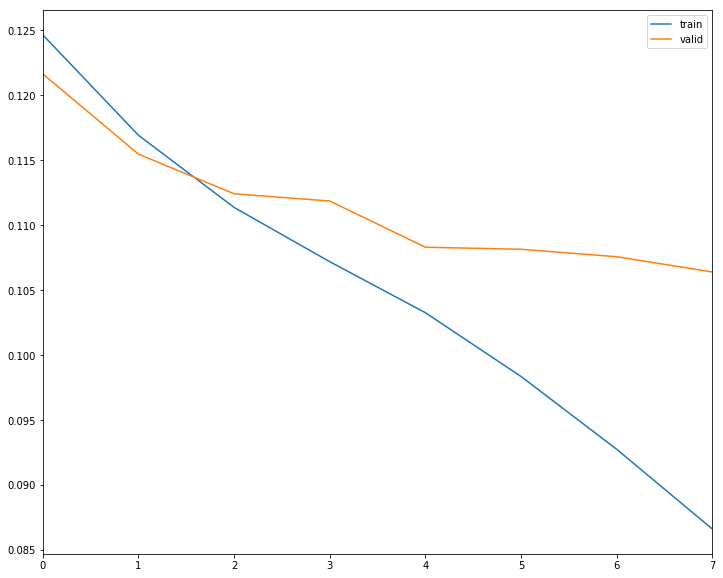

In [17]:
def plot_loss(loss):
    pd.DataFrame(loss).plot(figsize=(12,10))
plot_loss(losses)

# Infer Model

In [18]:
def predict(image, model, device='cpu'):
    img = image.unsqueeze(dim=0).to(device)
    model.to(device)
    model.eval()
    with torch.no_grad():
        # Forward
        pred = model(img)
        pred = pred.permute(0, 2, 3, 1)
    
    return pred.squeeze(), image.squeeze()

In [34]:
img_path = 'data/test/3.jpg'
transform = T.Compose([T.Resize(IMG_SIZE),
                       T.ToTensor()
                      ])
img = Image.open(img_path).convert('RGB')
img = transform(img)
        
image = img#.unsqueeze(dim=0).to(train_device)
# forward pass
pred, image = predict(image, model, train_device)

In [35]:
pred.shape

torch.Size([7, 7, 9])

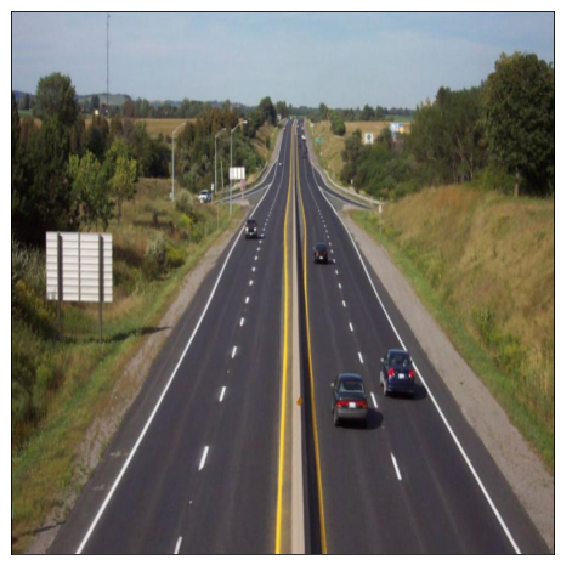

In [36]:
show_image(np.transpose(image.cpu().numpy(), (1, 2, 0)))

In [37]:
pred[:, :, 0].max()

tensor(0.0132)

In [38]:
def show_prediction(pred, img, thresh=.012, nms=False):
    
    # Move to cpu
    pred = pred.cpu().numpy()
    image= img.cpu().numpy()
    
    # Collect
    grid_width = IMG_SIZE[0] // GRID
    grid_height = IMG_SIZE[1] // GRID
    boxes = pred[:, :, 0:5]
    # Plot
    ax = show_image(np.transpose(image, (1,2,0)))
    for i in range(GRID):
        for j in range(GRID):
            rel_x = i * grid_width
            rel_y = j * grid_height
            (prob, x, y, delta_x, delta_y) = boxes[i, j]
            x, y = int(rel_x + x * grid_width), int(rel_y + y * grid_height)
            if prob > thresh:
#                 import ipdb; ipdb.set_trace()
                bound_rect = Rectangle((int(x - delta_x / 2 * grid_width),
                                        int(y - delta_y/2 * grid_height)),
                                        int(delta_x * grid_width),
                                        int(delta_y * grid_height),
                                        linewidth=6, edgecolor='r', facecolor='none')
                ax.add_patch(bound_rect)        

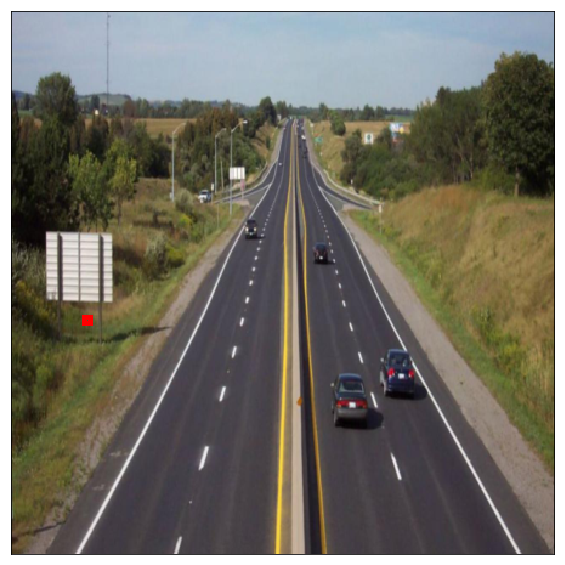

In [39]:
show_prediction(pred, image)

## TODO
- NON MAX SUPPRESSION
- CUSTOM LOSS FUNCTION

In [ ]:
# For each traning image
for i in glob.